# Analysis of WASP-189 (Eclipse - Visit 3) using `pycheops`

In the following notebook, we will analyse the data from `CHEOPS` visit 1 data of HD106315b using `pycheops`.

The method is similar to that used in the analysis of KELT-11b data ([https://github.com/Jayshil/pycheops-tutorials/blob/main/KELT-11/p2_kelt11_extra_decorr_parm.ipynb](https://github.com/Jayshil/pycheops-tutorials/blob/main/KELT-11/p2_kelt11_extra_decorr_parm.ipynb)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import lmfit as lmf
import re
from pycheops.utils import phaser
from pycheops.constants import c, au

## Downloading the data

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR100041_TG000203_V0200.tgz
 PI name     : David EHRENREICH
 OBS ID      : 1036349
 Target      : WASP-189
 Coordinates : 15:02:44.87 -03:01:53.0
 Spec. type  : A6V
 G magnitude : 6.55 +- 0.00
Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR100041_TG000203_V0200-DEFAULT.fits
Time stored relative to BJD = 2458938
Aperture radius used = 25 arcsec
UTC start:  2020-03-30T01:05:09
UTC end:    2020-03-30T13:29:47
Visit duration: 44678 s
Exposure time: 7 x 4.8 s
Number of non-flagged data points: 875
Efficiency (non-flagged data): 65.8 %
Light curve corrected for flux from background stars
Mean counts = 140991826.4
Median counts = 140991915.8
RMS counts = 57992.0 [411 ppm]
Median standard error = 11916.8 [85 ppm]
Median background = 272272 e-/pxl
Mean contamination = 718.2 ppm
Mean smearing correction = 18.7 ppm

Rejected 26 points more than 5.0 x MAD = 562 ppm from the median


/home/jayshil/anaconda3/lib/python3.8/site-packages/pycheops-0.9.17-py3.8.egg/pycheops/dataset.py:426: UserWarning: No metadata in file /home/jayshil/.local/share/pycheops/CH_PR100041_TG000203_V0200.tgz
  warnings.warn(msg)


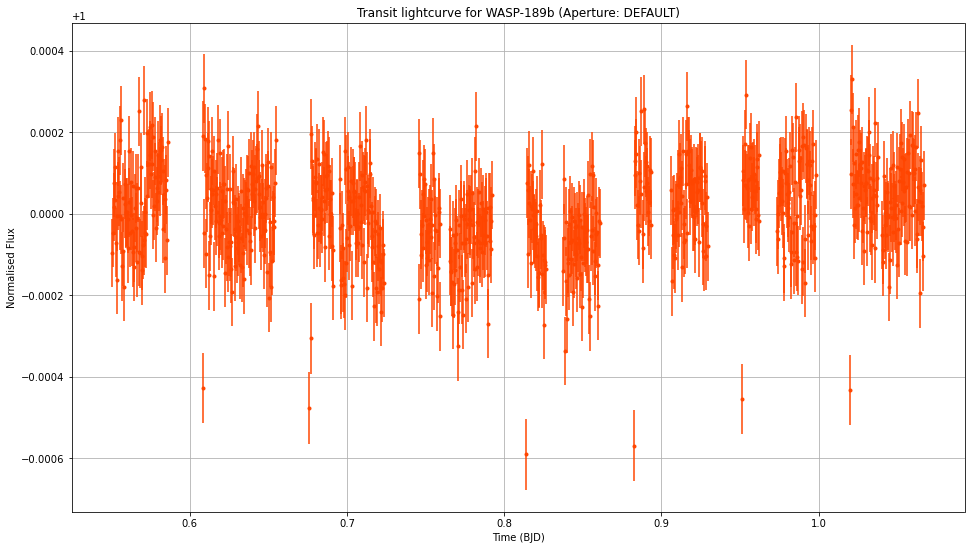

In [2]:
# Downloading data
dd = pycheops.Dataset('CH_PR100041_TG000203_V0200')
tim, fl, fle = dd.get_lightcurve(aperture='DEFAULT', decontaminate=True)#, reject_highpoints=True)

# To clip outliers (I would, in general, not prefer using this)
tim, fl, fle = dd.clip_outliers(verbose=True);

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for WASP-189b (Aperture: DEFAULT)')
plt.grid()

### Planetary check

We may want to check the position of various planetary bodies with respect to the target star, because if some of the bodies is very near to the target star then we may want to correct for their effects.

In [3]:
dd.planet_check()

BJD = 2458938.550652071
Body     R.A.         Declination  Sep(deg)
-------------------------------------------
Moon     04:41:51.07  +20:25:06.7      37.4
Mars     20:06:09.22  -21:13:52.2      37.9
Jupiter  19:43:03.21  -21:23:15.9      60.0
Saturn   20:09:54.36  -20:08:48.5      71.4
Uranus   02:10:39.36  +12:41:12.3     164.6
Neptune  23:20:52.15  -05:19:20.8     123.3


## Stellar and Planetary properties

A knowledge of the stellar and planetary property of the system under investigation can proved to be useful while analysing the system. We can use some of the properties as priors in our analysis. In `pycheops` there are some in-build tools  available which ca go through the available stellar and planetary catalogues (like SWEET-Cat, or DACE) to give us the properties. Below, we show how to access such properties.

In [4]:
# For planetary properties
# This cell is copied from pycheops examples notebook
# The planet properties will not provide good results
# Hence, we will use ExoCTK to get planetary parameters.
"""
try: 
    hd106315b = pycheops.PlanetProperties('HD 106315b',query_dace=True)
except:
    hd106315b = pycheops.PlanetProperties('HD 106315b',query_dace=False, query_tepcat=False,
                                    depth = ufloat(298.909, 20.791),   # PPM
                                    width = ufloat(0.1572,0.0034),  # days (that means that is transit duration -- in days)
                                    ecosw=0.,#ufloat(-0.0040, 0.0490), 
                                    esinw=0.,#ufloat(0.0310, 0.0680),
                                    T0 = ufloat(2457586.5487, 0.0029),
                                    P = ufloat(9.55237, 0.00089))
    
print(hd106315b)
"""
# Using ExoCTK to get planetary properties
#rprs = np.random.normal(0.07085738, 0.003144594526637345, 10000)
dep, dep_err = 0.00502077*1e6, 1.3388e-05*1e6

Well..., apparently, I cannot (even after studying two semesters at Geneva) access DACE-Planets. No problem --- we have TEPCat at our service. We derived parameters from there. We can now try searching for the host star.

In [5]:
"""
star = pycheops.StarProperties(dd.target)
print(star)
"""
teff = np.random.normal(8000, 80, 10000)
logg = np.random.normal(3.9, 0.2, 10000)
mh = np.random.normal(0.29, 0.13, 10000)
h1, h2 = np.zeros(10000), np.zeros(10000)
cdc = pycheops.ld.stagger_power2_interpolator('CHEOPS')
for i in range(len(teff)):
    c1, c2, h1[i], h2[i] = cdc(teff[i], logg[i], mh[i])

It seems that the program would return nan to h1 and h2 because the temperature is out of range of the grid. So, we will let free the h1 and h2 in the analysis.

We have it! Here `h_1` and `h_2` are power2 law limb darkening coefficients.

## Renormalising the lightcurve

It already seems pretty flatten -- and applying the function would only reduce the quality of the data.

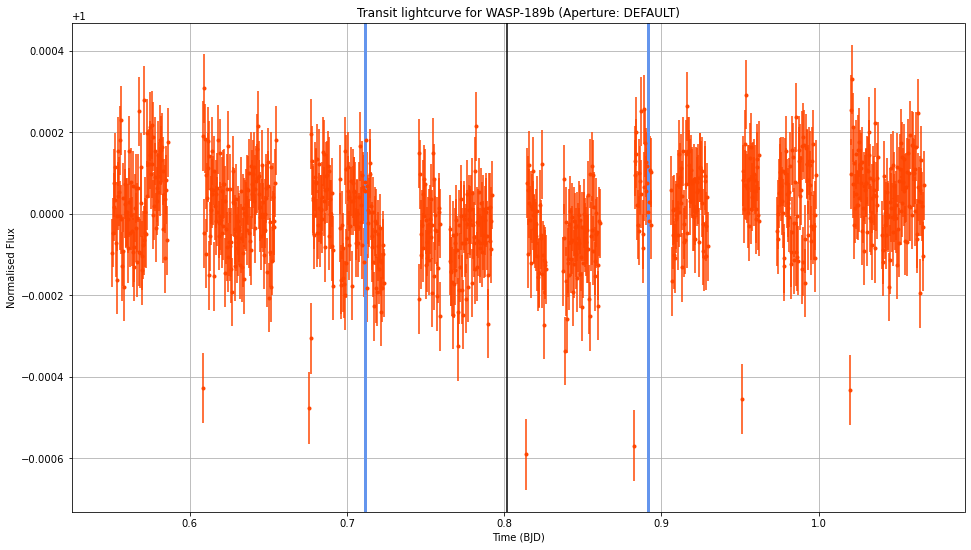

In [6]:
# This code is taken from the pycheops example notebook
P = 2.7240338
BJD_0 = 2456706.4558
cycle = round((dd.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dd.bjd_ref + (cycle+0)*P
T_ec = T_0 + (P/2)

a_c = 0.05053 * au/c / 86400

D = dep/1e6  # Depth stored in ppm
W = 0.06619157#0.1819/P    # Width stored in days

try:
    f_c = 0.#np.sqrt(0.093)*np.sin(67.0*np.pi/180)
    f_s = 0.#np.sqrt(0.093)*np.cos(67.0*np.pi/180)
except:
    # From Pepper et al., 2017
    ecosw = 0.#ufloat(-0.004,0.05099)
    esinw = 0.#ufloat(0.031,0.055)
    ecc = usqrt(ecosw**2+esinw**2)
    f_s = 0.#esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
    f_c = 0.#ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)


# Let's take data from first transit only
mask1 = tim < T_ec-(3*W*P)
mask2 = tim > T_ec + (3*W*P)
mask = mask1 + mask2

#tim, fl, fle = dd.mask_data(mask)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.axvline(T_ec, c='k')
plt.axvline(x=T_ec-(W*P/2), c='cornflowerblue', lw=3)
plt.axvline(x=T_ec+(W*P/2), c='cornflowerblue', lw=3)
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for WASP-189b (Aperture: DEFAULT)')
plt.grid()

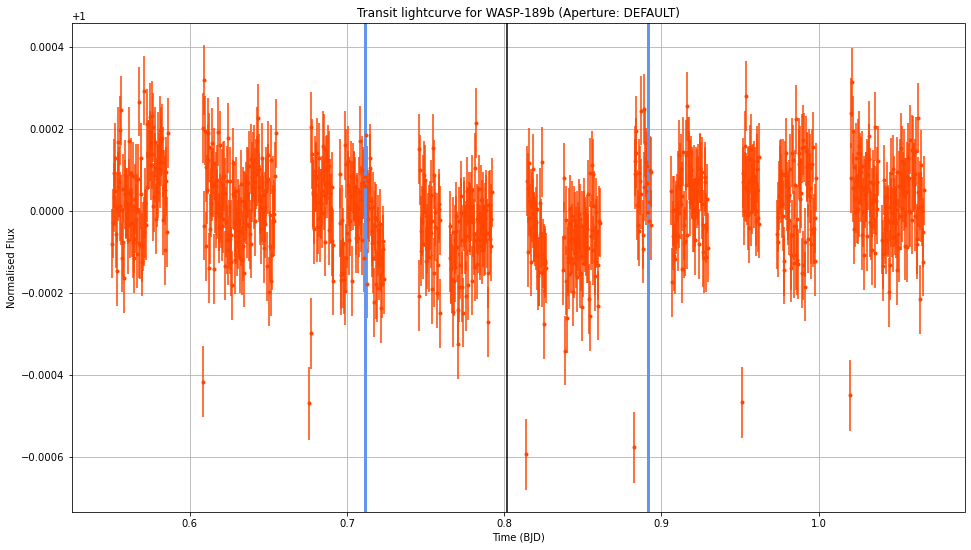

In [7]:
tim, fl, fle = dd.flatten(T_0, P*W)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.axvline(T_ec, c='k')
plt.axvline(x=T_ec-(W*P/2), c='cornflowerblue', lw=3)
plt.axvline(x=T_ec+(W*P/2), c='cornflowerblue', lw=3)
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for WASP-189b (Aperture: DEFAULT)')
plt.grid()

## Detrending (or, decorrelating) the dataset

To perform this operation of detrending we may want to look at diagnostic report for this observations. The diagnostic report consist of various plots of flux as a function of several instrumental properties like roll angle of the spacecraft, centroid position etc. This would enable us to see if there is any trend going on with instruments so that we can take care of it. So, first let's see the diagnostic report...

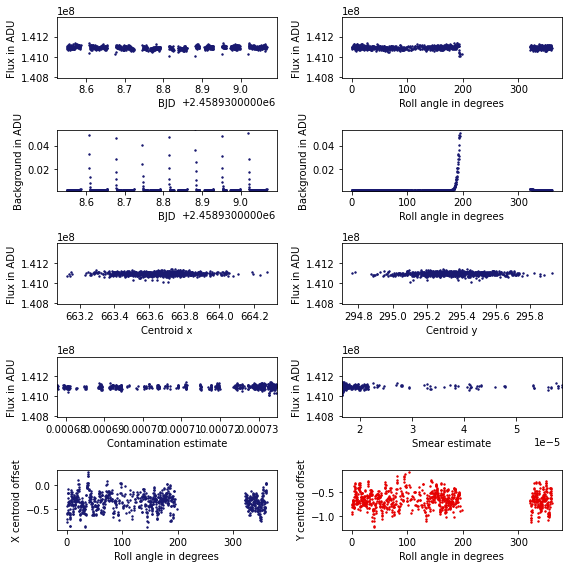

In [8]:
dd.diagnostic_plot()

### Ramp correction
A ramp in the flux is often observed, usually beginning the visit, in the lightcurves due to thermal effects (well, it primarily occurs due to small scale change in the shape of the PSF, which happens due to slightly more defocusing of the telescope. The main reason for the later is the thermal effects). The effect is well characterised for aperture radius between ~22 to 40 pixels. We can correct for this effect using the function `dataset.correct_ramp`.

Note that since this effect is well described only for a range of pixels, it is not advisable to make this correction if the aperture size is beyond this range.

In [9]:
#tim, fl, fle = dd.correct_ramp(plot=True)

### Performing decorrelation

We can see above that, `Dataset.should_I_decorr` function suggests that several decorrelations should be done. Various parameters shows different correlations with different properties of the instrument. From $\texttt{pycheops-cookbook}$ I mention where each of these parameters belong:

- flux versus time: $\texttt{dfdt}$, $\texttt{d2fdt2}$
- flux versus x-centroid: $\texttt{dfdx}$, $\texttt{d2fdx2}$
- flux versus y-centroid: $\texttt{dfdy}$, $\texttt{d2fdy2}$
- flux versus roll angle: $\texttt{dfdsinphi}$, $\texttt{dfdcosphi}$, $\texttt{dfdsin2phi}$, $\texttt{dfdcos2phi}$, $\texttt{dfdsin3phi}$, $\texttt{dfdcos3phi}$
- flux versus background: $\texttt{dfdbg}$
- flux versus contamination: $\texttt{dfdcontam}$
- flux versus smear: $\texttt{dfdsmear}$

Note that not each of the parameters have same units (especially $\texttt{dfdt}$), therefore, one may want to take care while defining these parameters in analysis.

There are (I think) two ways to take care of these correlations --- we can either use `dataset.decorr` function to take care of these correlations, or we can do it in the later stage of fitting the data. There is a little advantage of doing this in a later stage of curve fitting: if we do at that point, we can see the effect of <i>adding</i> parameters to the fitting with Bayes' factors. We can even neglect additional parameters which are not supported by the data.

Below, we try to include one by one parameter in the model and see its effect on the fitting in form of the Bayes' factor. However, before including decorrelation parameters, we fit <i>without</i> any decorrelation parameters. We can use results from this fitting as priors for the modelling which includes decorrelation parameters.

### Fitting without decorrelation

#### A note on using priors

The priors on the parameters can be find using `uncertainties` or `lmfit` module, or simply by using a tuple. To give normal priors with mean $\mu$ and standard deviation $\sigma^2$, one can use ufloat($\mu$, $\sigma^2$). A uniform prior with upper ($u$) and lower ($l$) bound can be given by a tuple ($l$, $u$), with initial value halfway of the range. If we want to specify the initial value ($in$), we can add it as a third term within the tuple, as ($l$, $in$, $u$). Furthermore, one can use [Parameter](https://lmfit.github.io/lmfit-py/parameters.html#the-parameter-class) object of `lmfit`. It can be defined as,

```
    lmfit.Parameter(name (str) = name of the parameter,
                    value (float) = numerical parameter value,
                    vary (bool) = Whether the parameter is varied during a fit (default is True,)
                    min (float) = lower bound (default is -np.inf),
                    max (float) = upper bound (default is np.inf),
                    expr (str) = mathematical expression used to constrain the value during the fit,
                    ***other kwargs)
```

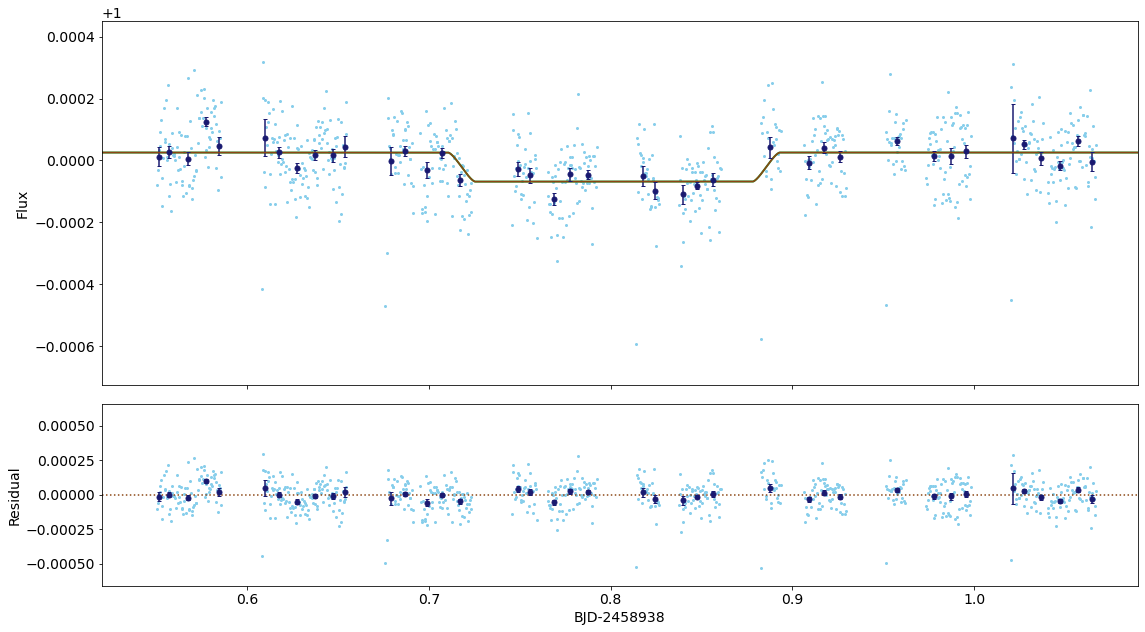

In [10]:
# Codes from the pycheops example notebook
lmfit0 = dd.lmfit_eclipse(T_0 = T_0, P=P, a_c=a_c,
                          D=0.00502077, W=ufloat(0.06619157, 5.4123e-05),
                          b=ufloat(0.43638546, 0.01208119), L=(1e-6,2e-4,1e-3),
                          f_c=f_c, f_s=f_s)

dd.plot_lmfit(binwidth=0.01, figsize=(16,9), fontsize=14);
#plt.ylim([-0.001, 0.001])

Well, it is not that bad! Let's try to decorrelate it.

It should be mentioned that we have used only transit model here, but, in reality one should use transit <i>and</i> eclipse model as the eclipse dip is also observed between two transits.

In [11]:
print(dd.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 814
    # variables        = 4
    chi-square         = 1235.57609
    reduced chi-square = 1.52540258
    Akaike info crit   = -12527.6995
    Bayesian info crit = -12508.8916
    RMS residual       = 104.7 ppm
[[Variables]]
    T_0:  -0.5605178 (fixed)
    P:     2.724034 (fixed)
    D:     0.00502077 (fixed)
    W:     0.06619117 +/- 6.6704e-05 (0.10%) (init = 0.06619157)
    b:     0.43549282 +/- 0.01489157 (3.42%) (init = 0.4363855)
    L:     9.3871e-05 +/- 8.4771e-06 (9.03%) (init = 0.0002)
    f_c:   0 (fixed)
    f_s:   0 (fixed)
    c:     1.00002561 +/- 4.3193e-06 (0.00%) (init = 1)
    a_c:   0.0002918369 (fixed)
    k:     0.07085739 +/- 0.00000000 (0.00%) == 'sqrt(D)'
    aR:    4.70461998 +/- 0.03223518 (0.69%) == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:  0.99570645 +/- 2.9427e-04 (0.03%) == 'sqrt(1 - (b/aR)**2)'
    e:     0.00000000 +/- 0.00000000  == 'f_c**2 + f_s**2'


### Fitting with decorrelation

We now attempt to fit the data with decorrelation parameters. As said previously, we add one by one decorrelation parameters in the fitting procedure and check the Bayes' factor each time.

We first want to check the RMS of the residuals which we can use as standard deviation of decorrelation parameters' priors in the fitting.

In [12]:
sigma0 = lmfit0.rms
dprior = ufloat(0, sigma0)
tprior = ufloat(0, sigma0/np.ptp(tim)) # Remember? Some of the priors, like dfdt, has different units.

In [13]:
# This code is taken from pycheops example notebook
detrend = {}
bestbf = 0
#"""
allpar = ['dfdsinphi','dfdcosphi',
          'dfdsin2phi','dfdcos2phi',
          'dfdsin3phi','dfdcos3phi',
          'dfdx', 'dfdy', 'dfdsmear',
          'dfdbg','dfdt', 'dfdcontam']
#"""
#allpar = ['dfdbg', 'dfdsmear', 'dfdt', 'dfdx', 'dfdy', 'dfdcontam', 'dfdsinphi', 'dfdcosphi']

print('Parameter     BF     Delta_BIC RMS(ppm)')

while bestbf < 1:
    bestbf = np.inf
    for p in allpar: # This loop will put one by one parameter in the fit and see which one produce lowest Bayes' factor.
        dtmp = detrend.copy() ## Copy Updated detrend dictionary to temporary dtmp dict
        dtmp[p] = tprior if p == 'dfdt' else dprior
        lmfit = dd.lmfit_eclipse(T_0 = T_0, P=P, a_c=a_c,
                                 D=0.00502077, W=ufloat(0.06619157, 5.4123e-05),
                                 b=ufloat(0.43638546, 0.01208119), L=(1e-6,2e-4,1e-3),
                                 f_c=f_c, f_s=f_s, **dtmp)
        bre = re.compile(r'{}: *(\d+\.\d{{3}})\n'.format(p))
        m = bre.findall(dd.lmfit_report())
        if len(m) > 0:
            bf = float(m[-1])
            if bf < bestbf:
                bestbf = bf
                newpar = p

    if bestbf < 1: # This condition will add lowest Bayes' factor parameter into detrend dict. if it has Bayes' factor <1
        print(f'+{newpar:<12s} {bestbf:6.2f}  {lmfit.bic-lmfit0.bic:8.1f} {1e6*lmfit.rms:8.1f}')
        detrend[newpar] = tprior if newpar == 'dfdt' else dprior
        allpar.remove(newpar) # If parameter is added to the dict then get removed from list of all parameters

# This process sometimes leads to a set of parameters that includes a few parameters that are strongly correlated with one another 
# and so are therefore not well determined, i.e. they have large Bayes factors. 
# So, after adding parameters one-by-one, go through a process of repeatedly removing the parameter with the largest Bayes factor 
# if any of the parameters have a Bayes factors Bp>1.

worstbf = 10
while worstbf > 1:
    worstbf = 0
    for p in detrend: # This loop finds the parameter with largest Bayes' factor
        bre = re.compile(r'{}: *(\d+\.\d{{3}})\n'.format(p))
        m = bre.findall(dd.lmfit_report())
        if len(m) > 0:
            bf = float(m[-1])
            if bf > worstbf:
                worstbf = bf
                delpar = p
    if worstbf > 1: # This condition removes the parameter with largest Bayes' factor if it is >1
        del detrend[delpar] 
        lmfit = dd.lmfit_eclipse(T_0 = T_0, P=P, a_c=a_c,
                                 D=0.00502077, W=ufloat(0.06619157, 5.4123e-05),
                                 b=ufloat(0.43638546, 0.01208119), L=(1e-6,2e-4,1e-3),
                                 f_c=f_c, f_s=f_s, **detrend)
        print(f'-{delpar:<12s} {worstbf:6.2f}  {lmfit.bic-lmfit0.bic:8.1f} {1e6*lmfit.rms:8.1f}')

Parameter     BF     Delta_BIC RMS(ppm)
+dfdcos2phi     0.00     -40.7    102.7
+dfdbg          0.00     -64.3    101.4
+dfdcosphi      0.31    -135.1     97.7
+dfdcontam      0.83    -145.3     96.9


The remained parameters which would be useful in decorrelating are (the ones which are stored in `detrend` dictionary). Note that the different between BIC is reducing with each addition/removal of the parameter.

In [14]:
print(detrend)

{'dfdcos2phi': 0.0+/-0.00010470269716081771, 'dfdbg': 0.0+/-0.00010470269716081771, 'dfdcosphi': 0.0+/-0.00010470269716081771, 'dfdcontam': 0.0+/-0.00010470269716081771}


We can now use this parameters to detrend the dataset using the `lmfit_eclipse` function.

In [15]:
lmfit1 = dd.lmfit_eclipse(T_0 = T_0, P=P, a_c=a_c,
                          D=0.00502077, W=ufloat(0.06619157, 5.4123e-05),
                          b=ufloat(0.43638546, 0.01208119), L=(1e-6,2e-4,1e-3),
                          f_c=f_c, f_s=f_s, **detrend)

# Note the usage of .n in star.h_2.n which means that it will retrieve only one value and thus fixing the parameter.
print(dd.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 814
    # variables        = 8
    chi-square         = 1063.47461
    reduced chi-square = 1.31944741
    Akaike info crit   = -12691.8010
    Bayesian info crit = -12654.1853
    RMS residual       = 96.9 ppm
[[Variables]]
    T_0:        -0.5605178 (fixed)
    P:           2.724034 (fixed)
    D:           0.00502077 (fixed)
    W:           0.06619400 +/- 6.2368e-05 (0.09%) (init = 0.06619157)
    b:           0.43560753 +/- 0.01392372 (3.20%) (init = 0.4363855)
    L:           9.9659e-05 +/- 7.9823e-06 (8.01%) (init = 0.0002)
    f_c:         0 (fixed)
    f_s:         0 (fixed)
    c:           1.00003956 +/- 1.4146e-05 (0.00%) (init = 1)
    a_c:         0.0002918369 (fixed)
    dfdbg:      -4.2201e-04 +/- 5.6582e-05 (13.41%) (init = 0)
    dfdcontam:  -4.5458e-05 +/- 2.5369e-05 (55.81%) (init = 0)
    dfdcosphi:  -1.4107e-05 +/- 4.3635e-06 (30.93%) (init = 0)
    dfdcos2phi

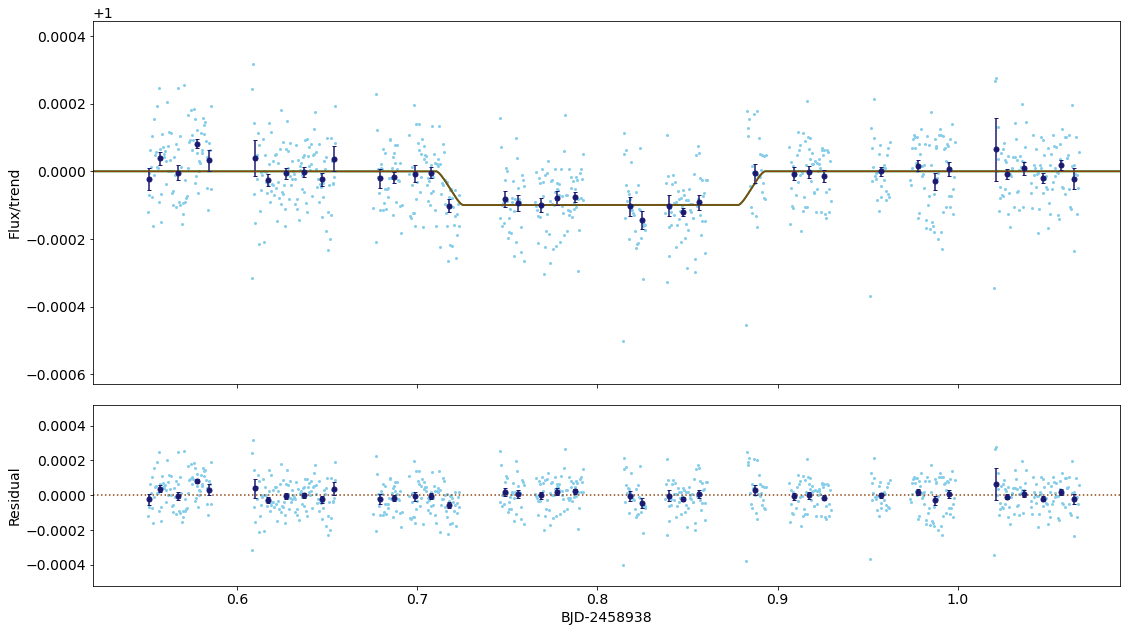

In [16]:
# We can plot the fitting
dd.plot_lmfit(binwidth=0.01, figsize=(16,9), fontsize=14, detrend=True);
#plt.ylim([-0.001, 0.001])

In above plot, light blue points are flux/trend, while the dark blue ones are the binned flux/trend. Transit model is shown in green and (transit model/trend) is brown line.

We can now check the roll angle plot to see if there is any trend remains. `dataset.rollangle_plot` gives the plot of residuals in the last fit with respect to the roll angle.

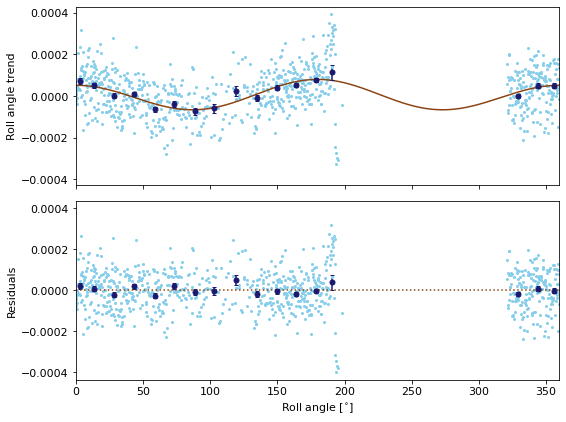

In [17]:
fig = dd.rollangle_plot()
#plt.ylim([-0.00075, 0.00075])

In [18]:
dd.save()

'WASP-189__CH_PR100041_TG000203_V0200.dataset'

## GP Fitting with fixed transit parameters

In [19]:
# This code if from the pycheops notebook
# Copy the parameters from the last lmfit
params_fixed = dd.lmfit.params.copy() 

# Fix the transit parameters
for p in ['W','b','L']:
    params_fixed[p].set(vary=False)

# Use emcee to sample the PPD. Note we add the SHOTerm at this step.
# add_shorterm determines whether to include short term noise in the modelling or not.
result = dd.emcee_sampler(params=params_fixed, add_shoterm=True, 
                          burn=1024,steps=512,nwalkers=256)

Running burn-in ..


100%|██████████| 1024/1024 [21:11<00:00,  1.24s/it]

Running sampler ..



100%|██████████| 512/512 [10:31<00:00,  1.23s/it]


In [20]:
print(dd.emcee_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 367232
    # data points      = 814
    # variables        = 8
    chi-square         = 1065.20501
    reduced chi-square = 1.32159430
    Akaike info crit   = -12728.7277
    Bayesian info crit = -12691.1120
    RMS residual       = 97.0 ppm
[[Variables]]
    T_0:        -0.5605178 (fixed)
    P:           2.724034 (fixed)
    D:           0.00502077 (fixed)
    W:           0.066194 (fixed)
    b:           0.4356075 (fixed)
    L:           9.965852e-05 (fixed)
    f_c:         0 (fixed)
    f_s:         0 (fixed)
    c:           1.00004063 +/- 1.9401e-05 (0.00%) (init = 1)
    a_c:         0.0002918369 (fixed)
    dfdbg:      -3.9468e-04 +/- 5.4378e-05 (13.78%) (init = 0)
    dfdcontam:  -4.7110e-05 +/- 2.4990e-05 (53.05%) (init = 0)
    dfdcosphi:  -1.3839e-05 +/- 4.5643e-06 (32.98%) (init = 0)
    dfdcos2phi:  6.6917e-05 +/- 1.2179e-05 (18.20%) (init = 0)
    k:           0.07085739 +/- 0.00000000 (0.00%)

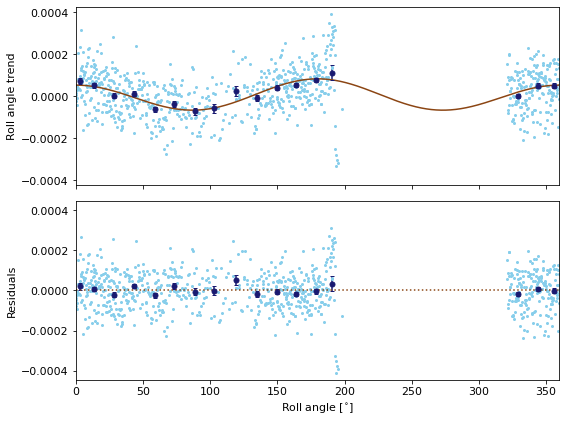

In [21]:
fig = dd.rollangle_plot()

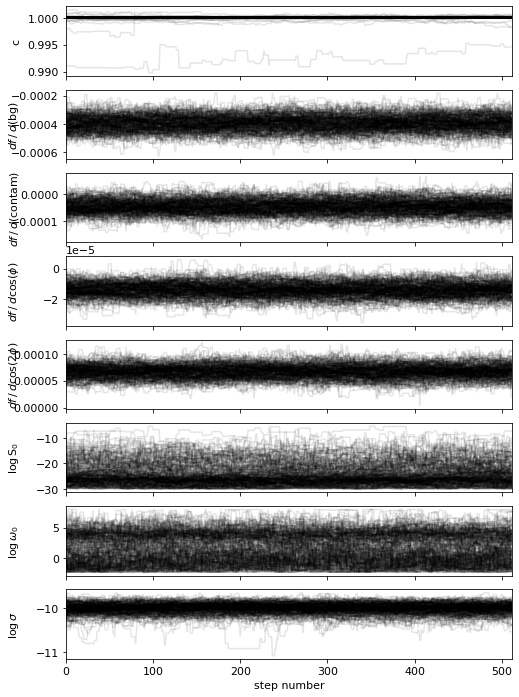

In [22]:
fig = dd.trail_plot('all')

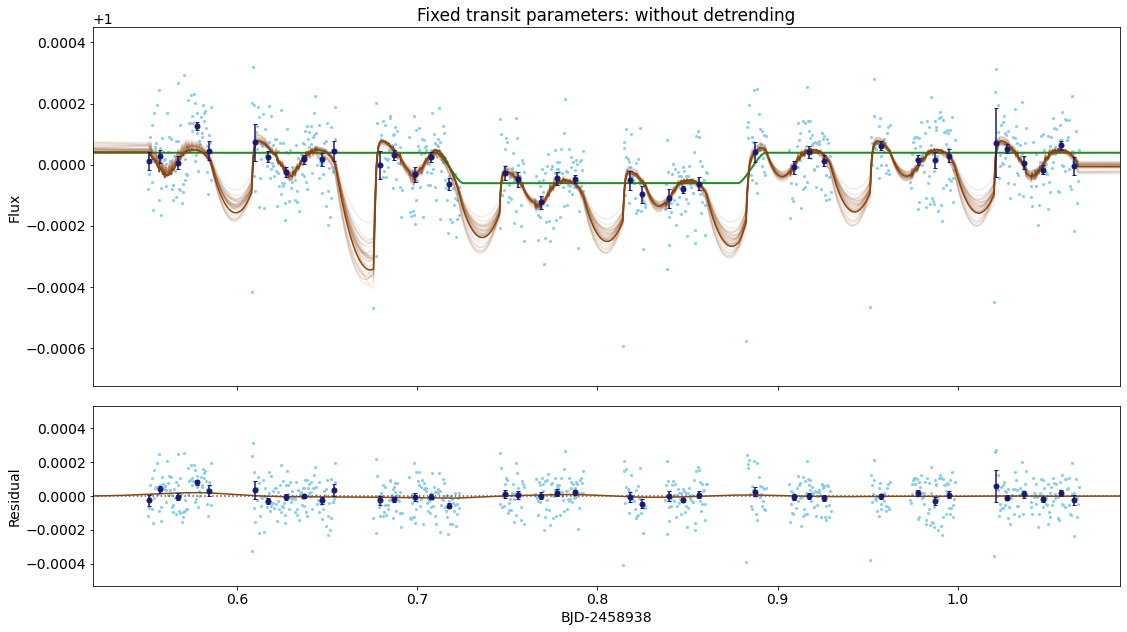

In [23]:
fig  = dd.plot_emcee(binwidth=0.01, figsize=(16,9), fontsize=14,
                     title='Fixed transit parameters: without detrending')

#plt.ylim([-0.001, 0.001])

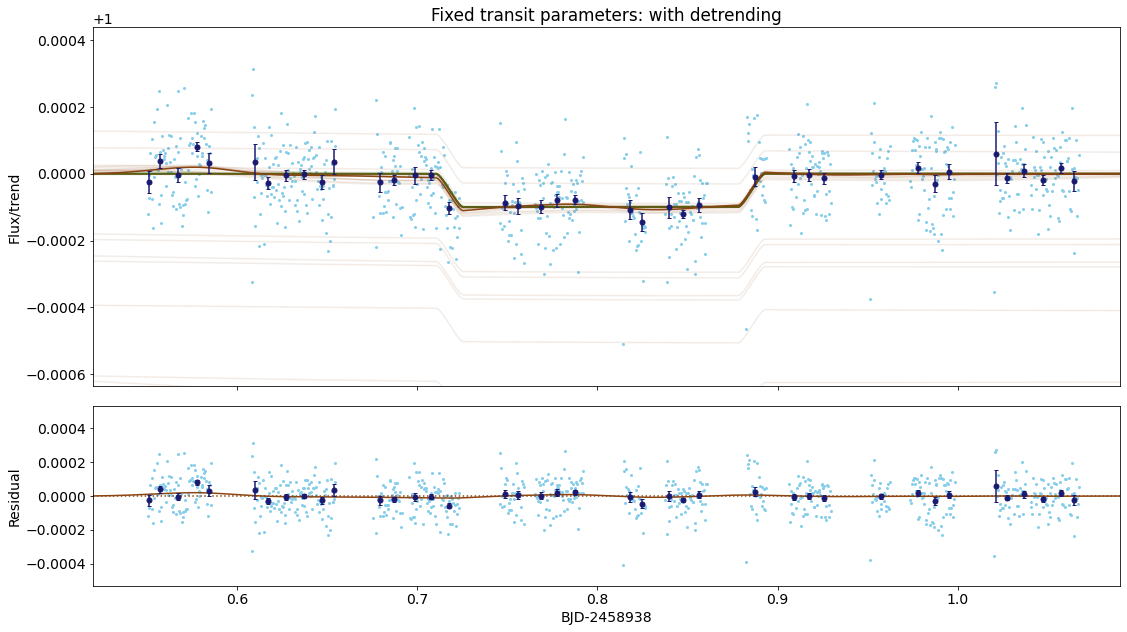

In [24]:
fig  = dd.plot_emcee(binwidth=0.01, figsize=(16,9), fontsize=14, detrend=True,
                     title='Fixed transit parameters: with detrending')
#plt.ylim([-0.001, 0.001])

## Full GP Fitting

In [25]:
# First we copy the posteriors from emcee fitting to a dictionary which we can use as prior in this fitting
params_free = dd.emcee.params.copy()

# Changing the priors on the noise parameters
for i in ['log_S0', 'log_omega0', 'log_sigma']:
    params_free[p].user_data = ufloat(nominal_value=params_free[p].value, std_dev=params_free[p].stderr)

# Letting the transit model parameters free

for p in ['W', 'b','L']:
    params_free[p].set(vary=True)

In [26]:
result = dd.emcee_sampler(params=params_free, burn=1024, steps=512, nwalkers=256)
print(dd.emcee_report())

Running burn-in ..


100%|██████████| 1024/1024 [21:40<00:00,  1.27s/it]

Running sampler ..



100%|██████████| 512/512 [10:59<00:00,  1.29s/it]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 391921
    # data points      = 814
    # variables        = 11
    chi-square         = 1067.72758
    reduced chi-square = 1.32967320
    Akaike info crit   = -12722.6031
    Bayesian info crit = -12670.8816
    RMS residual       = 97.1 ppm
[[Variables]]
    T_0:        -0.5605178 (fixed)
    P:           2.724034 (fixed)
    D:           0.00502077 (fixed)
    W:           0.06619195 +/- 5.4513e-05 (0.08%) (init = 0.06619157)
    b:           0.43523018 +/- 0.01205390 (2.77%) (init = 0.4363855)
    L:           9.9247e-05 +/- 6.2310e-06 (6.28%) (init = 0.0002)
    f_c:         0 (fixed)
    f_s:         0 (fixed)
    c:           1.00003961 +/- 1.7326e-05 (0.00%) (init = 1)
    a_c:         0.0002918369 (fixed)
    dfdbg:      -3.9502e-04 +/- 5.4152e-05 (13.71%) (init = 0)
    dfdcontam:  -4.6020e-05 +/- 2.4718e-05 (53.71%) (init = 0)
    dfdcosphi:  -1.3756e-05 +/- 4.5587e-06 (33.14%) (init = 0)
    dfdcos2

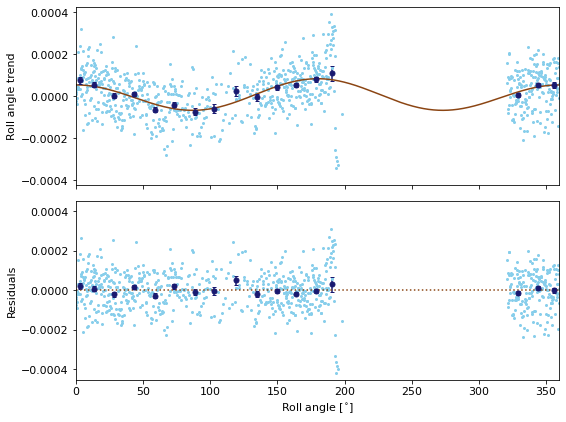

In [27]:
fig = dd.rollangle_plot()
#plt.ylim([-0.001, 0.001])

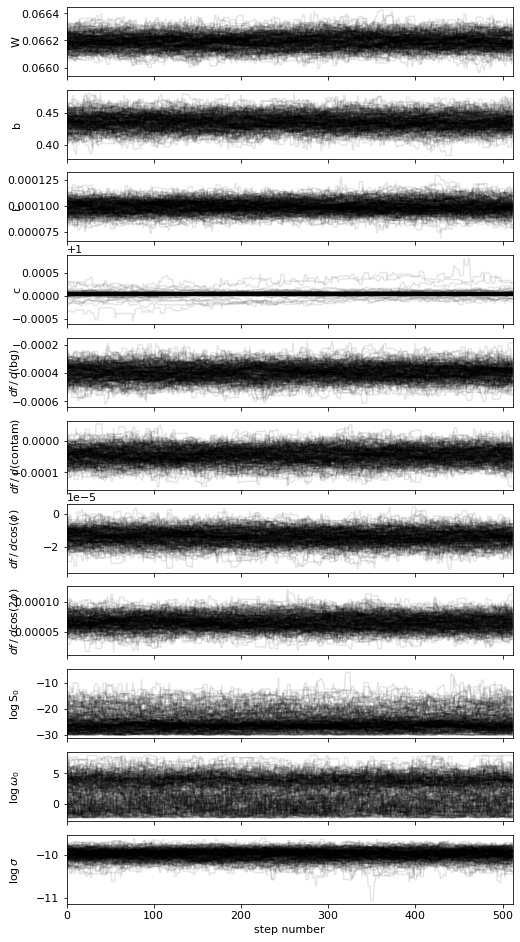

In [28]:
fig = dd.trail_plot('all')

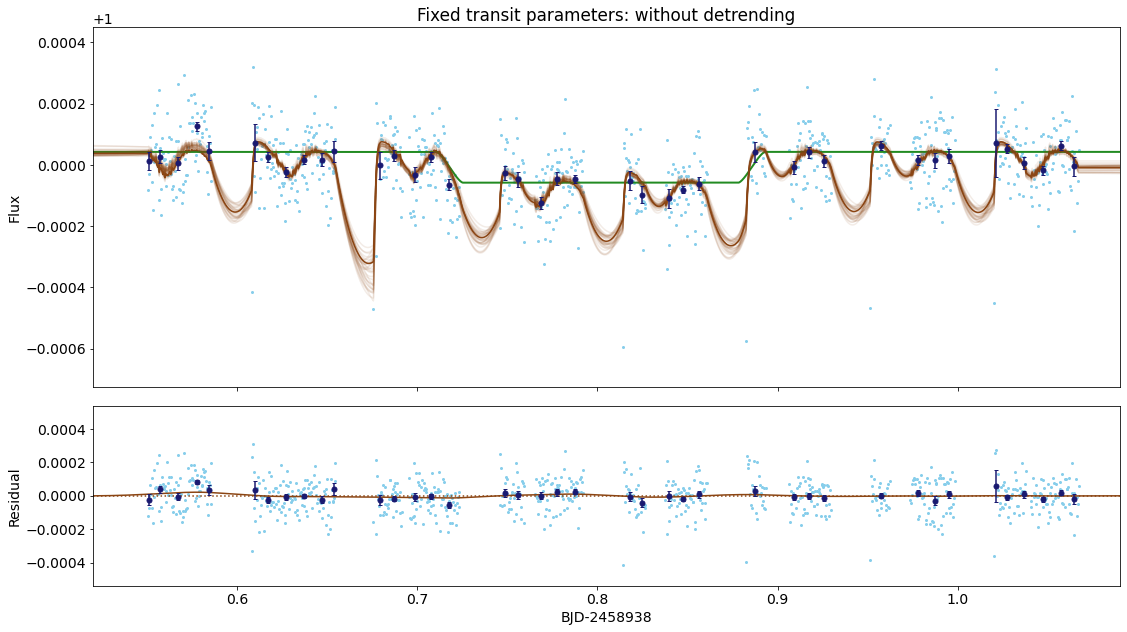

In [29]:
fig  = dd.plot_emcee(binwidth=0.01, figsize=(16,9), fontsize=14,
                     title='Fixed transit parameters: without detrending')
#plt.ylim([-0.001, 0.001])

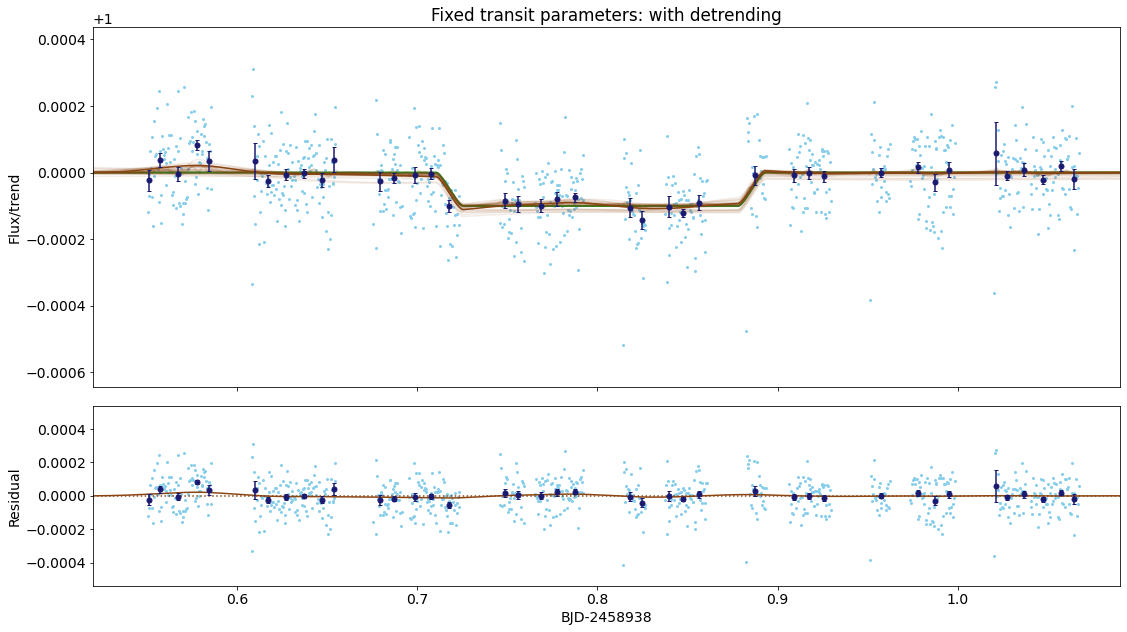

In [30]:
fig  = dd.plot_emcee(binwidth=0.01, figsize=(16,9), fontsize=14, detrend=True,
                     title='Fixed transit parameters: with detrending')
#plt.ylim([-0.001, 0.001])

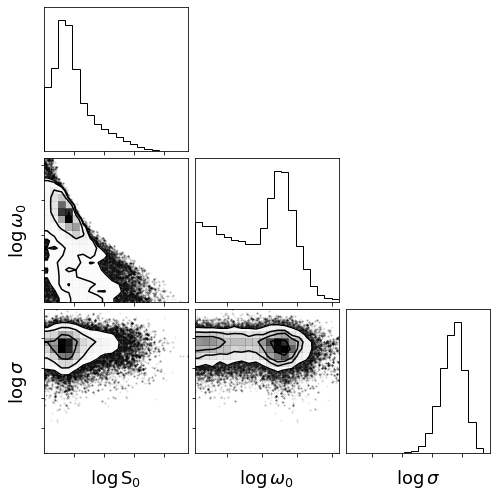

In [31]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 18}
fig = dd.corner_plot(
    plotkeys=['log_S0','log_omega0','log_sigma'],
    kwargs={'label_kwargs':{'fontdict':font}})

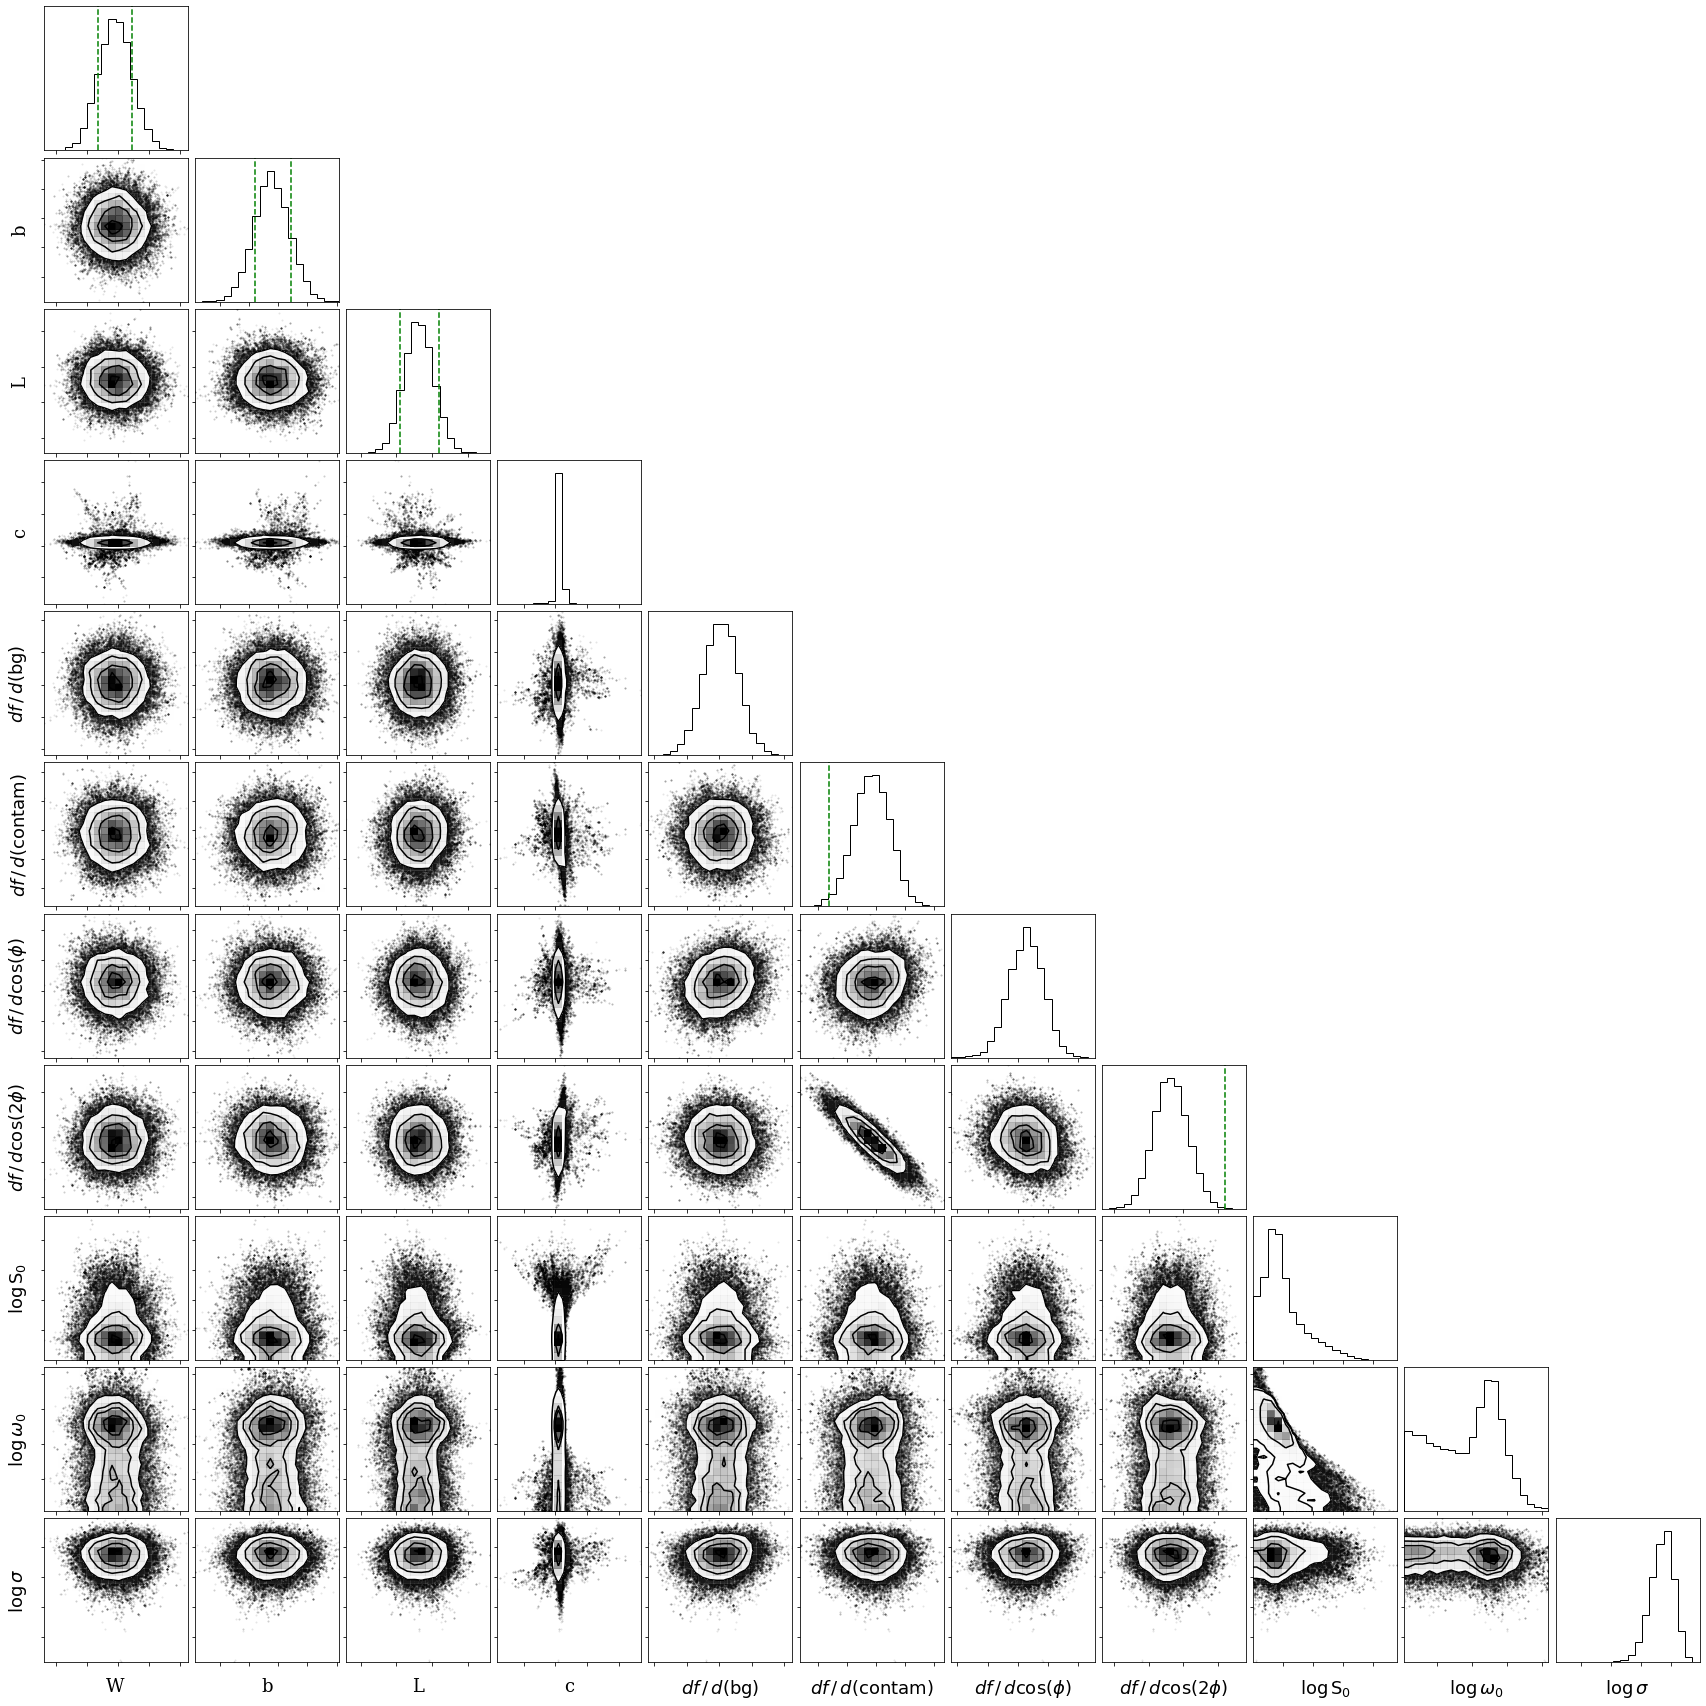

In [32]:
fig = dd.corner_plot(plotkeys='all', kwargs={'label_kwargs':{'fontdict':font}})